In [1]:
%pylab notebook
from PIL import Image
import soundfile as sf
import pygame
from time import sleep

def getChunk(arr, bSize=256, overlap=0):
    """
        bSize = how many samples are consumed per block
        overlap = how many additional old samples shall be added to the end
    """
    nRows = int(ceil(arr.size / bSize)) + 1
    mat = resize(arr, (nRows, bSize))
    mat.ravel()[arr.size:] = 0
    scratch = zeros(overlap, dtype=arr.dtype)
    for c in mat:
        yield hstack((scratch, c))
        scratch[:] = c[-overlap:]

Populating the interactive namespace from numpy and matplotlib


# Overlap add test
with different FFT lengths

In [5]:
testDat = array([3, -1, 0, 3, 2, 0, 1, 2, 1])
h_t = array([1, -1, 1])

#---------------------------
# Overlap save parameters
#---------------------------
M = len(h_t)   # Length of repsonse
O = M - 1      # Overlap
N = 8          # FFT length (adjustable)
L = N - O      # Consumed samples per iteration

print(M, O, N, L)

res = list()
h_f = fft.rfft(h_t, N)
print("h_f", h_f)
for c_t in getChunk(testDat, L, O):
    print("---------------------")
    print("c_t", c_t)
    c_f = fft.rfft(c_t, N)
    print("c_f", c_f)
    y_f = c_f * h_f
    print("y_f", y_f)
    y_t = fft.irfft(y_f, N)
    print("y_t", y_t)
    print("res", y_t[O:])
    res.append(y_t[O:])
res = hstack(res)
res

3 2 8 6
h_f [1.        +0.j         0.29289322-0.29289322j 0.        +1.j
 1.70710678+1.70710678j 3.        +0.j        ]
---------------------
c_t [ 0  0  3 -1  0  3  2  0]
c_f [ 7.        +0.j         -1.41421356+1.82842712j -5.        -4.j
  1.41421356+3.82842712j  3.        +0.j        ]
y_f [ 7.        +0.j          0.12132034+0.94974747j  4.        -5.j
 -4.12132034+8.94974747j  9.        +0.j        ]
y_t [ 2.00000000e+00 -2.22044605e-16  3.00000000e+00 -4.00000000e+00
  4.00000000e+00  2.00000000e+00 -1.00000000e+00  1.00000000e+00]
res [ 3. -4.  4.  2. -1.  1.]
---------------------
c_t [2 0 1 2 1 0 0 0]
c_f [ 6.        +0.j         -0.41421356-2.41421356j  2.        +2.j
  2.41421356-0.41421356j  2.        +0.j        ]
y_f [ 6.        +0.j         -0.82842712-0.58578644j -2.        +2.j
  4.82842712+3.41421356j  6.        +0.j        ]
y_t [ 2.00000000e+00 -2.00000000e+00  3.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00 -1.11022302e-16]
res [ 

/home/michael/miniconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


array([ 3.00000000e+00, -4.00000000e+00,  4.00000000e+00,  2.00000000e+00,
       -1.00000000e+00,  1.00000000e+00,  3.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  1.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

# Load image

(128, 220)


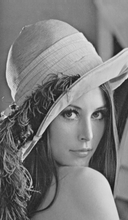

In [2]:
xOffs = 45
img = Image.open("./220px-Lenna_(test_image).png").convert("L")
img = img.crop([xOffs, 0, xOffs+128, img.size[1]])
print(img.size)
imgDat = asarray(img)
img

# Real overlap add

In [3]:
aDat, sRate = sf.read("/home/michael/Music/singleFiles/08 Kettcar - Balu.ogg", always_2d=True)
aDat = mean(aDat, 1)
print(sRate, aDat.shape)

44100 (12157488,)


In [23]:
#---------------------------
# Overlap save parameters
#---------------------------
N = 2**10                # FFT length (pow. of 2)
h_f = zeros(N//2+1, dtype=complex)
h_f[0:20] = 1
M = len(h_f)             # Length of filter repsonse
O = M - 1                # Overlap
L = N - O                # Consumed samples per iteration
print(M, O, N, L)
res = list()
for i, c_t in enumerate(getChunk(aDat, L, O)):
    c_f = fft.rfft(c_t, N)
    y_f = c_f * h_f
    y_t = fft.irfft(y_f, N)
    res.append(y_t[O:])
res = hstack(res)

513 512 1024 512


In [ ]:
# Get pixel line and normalize
#row = imgDat[(i // 4) % imgDat.shape[0], :].astype("float")
#row = imgDat[45, :].astype("float")
#row -= min(row)
#row /= max(row)

# Play filtered sound

In [5]:
pygame.mixer.pre_init(sRate, size=-16, channels=1)
pygame.mixer.init()

In [20]:
c = pygame.sndarray.make_sound((res * (2**15)).astype(int16)).play()

In [6]:
c = pygame.sndarray.make_sound((aDat * (2**15)).astype(int16)).play()

In [21]:
c.stop()

# Plot filter

<IPython.core.display.Javascript object>


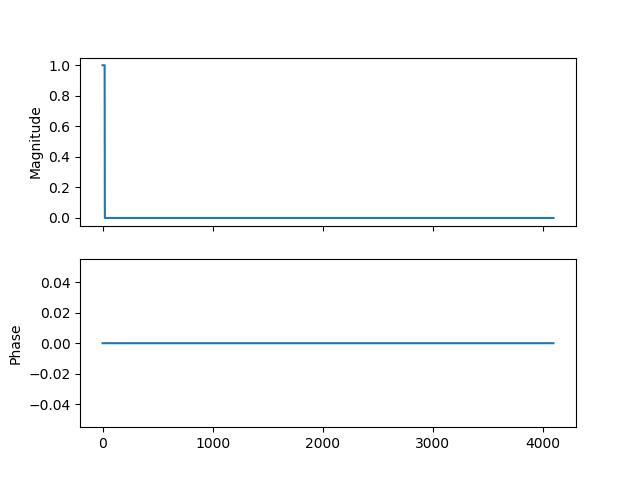

Text(0,0.5,'Phase')

In [7]:
fig, axs = subplots(2, 1, True, False)
axs[0].plot(abs(h_f))
axs[1].plot(angle(h_f))
axs[0].set_ylabel("Magnitude")
axs[1].set_ylabel("Phase")

<IPython.core.display.Javascript object>


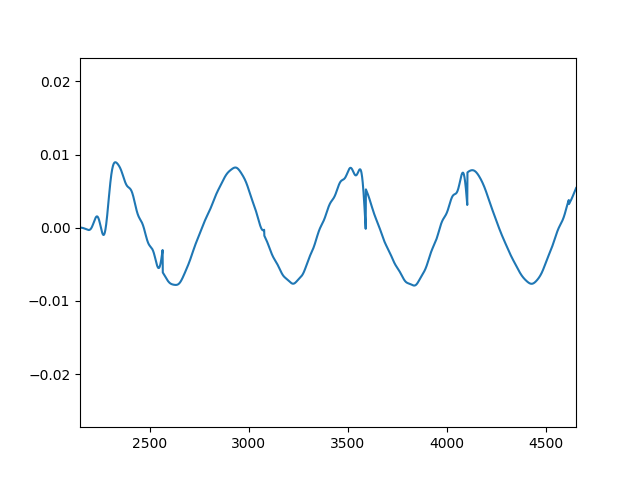

In [15]:
close("all")
plot(res[:5*sRate])